In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from src.model.eegnet import EEGNet
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
import pandas as pd


Section for visualizing data:

In [3]:
files = get_raw_file_paths('src/pickle_df')

# Load one dataframe
df = pd.read_pickle(files[0])

In [4]:
subjects = 6
sessions = 2
       
trials = [[[[], []]for _ in range(sessions)] for _ in range(subjects)]

for file in files:
    subject = int(file.split('/')[-1][8]) - 1
    session = int(file.split('/')[-1][11]) - 1
    recordings = process_recording(file)

    for recording in recordings:
        if recording[1] == 0:
            trials[subject][session][0].append(recording[0])
        elif recording[1] == 1:
            trials[subject][session][1].append(recording[0])

In [5]:
mean_trials = []

for i, subject in enumerate(trials):
    mean_trials.append([])
    for session in subject:
        mean_trials[i].append((
            np.mean(np.array(session[0]), axis=0),
            np.mean(np.array(session[1]), axis=0)
        ))

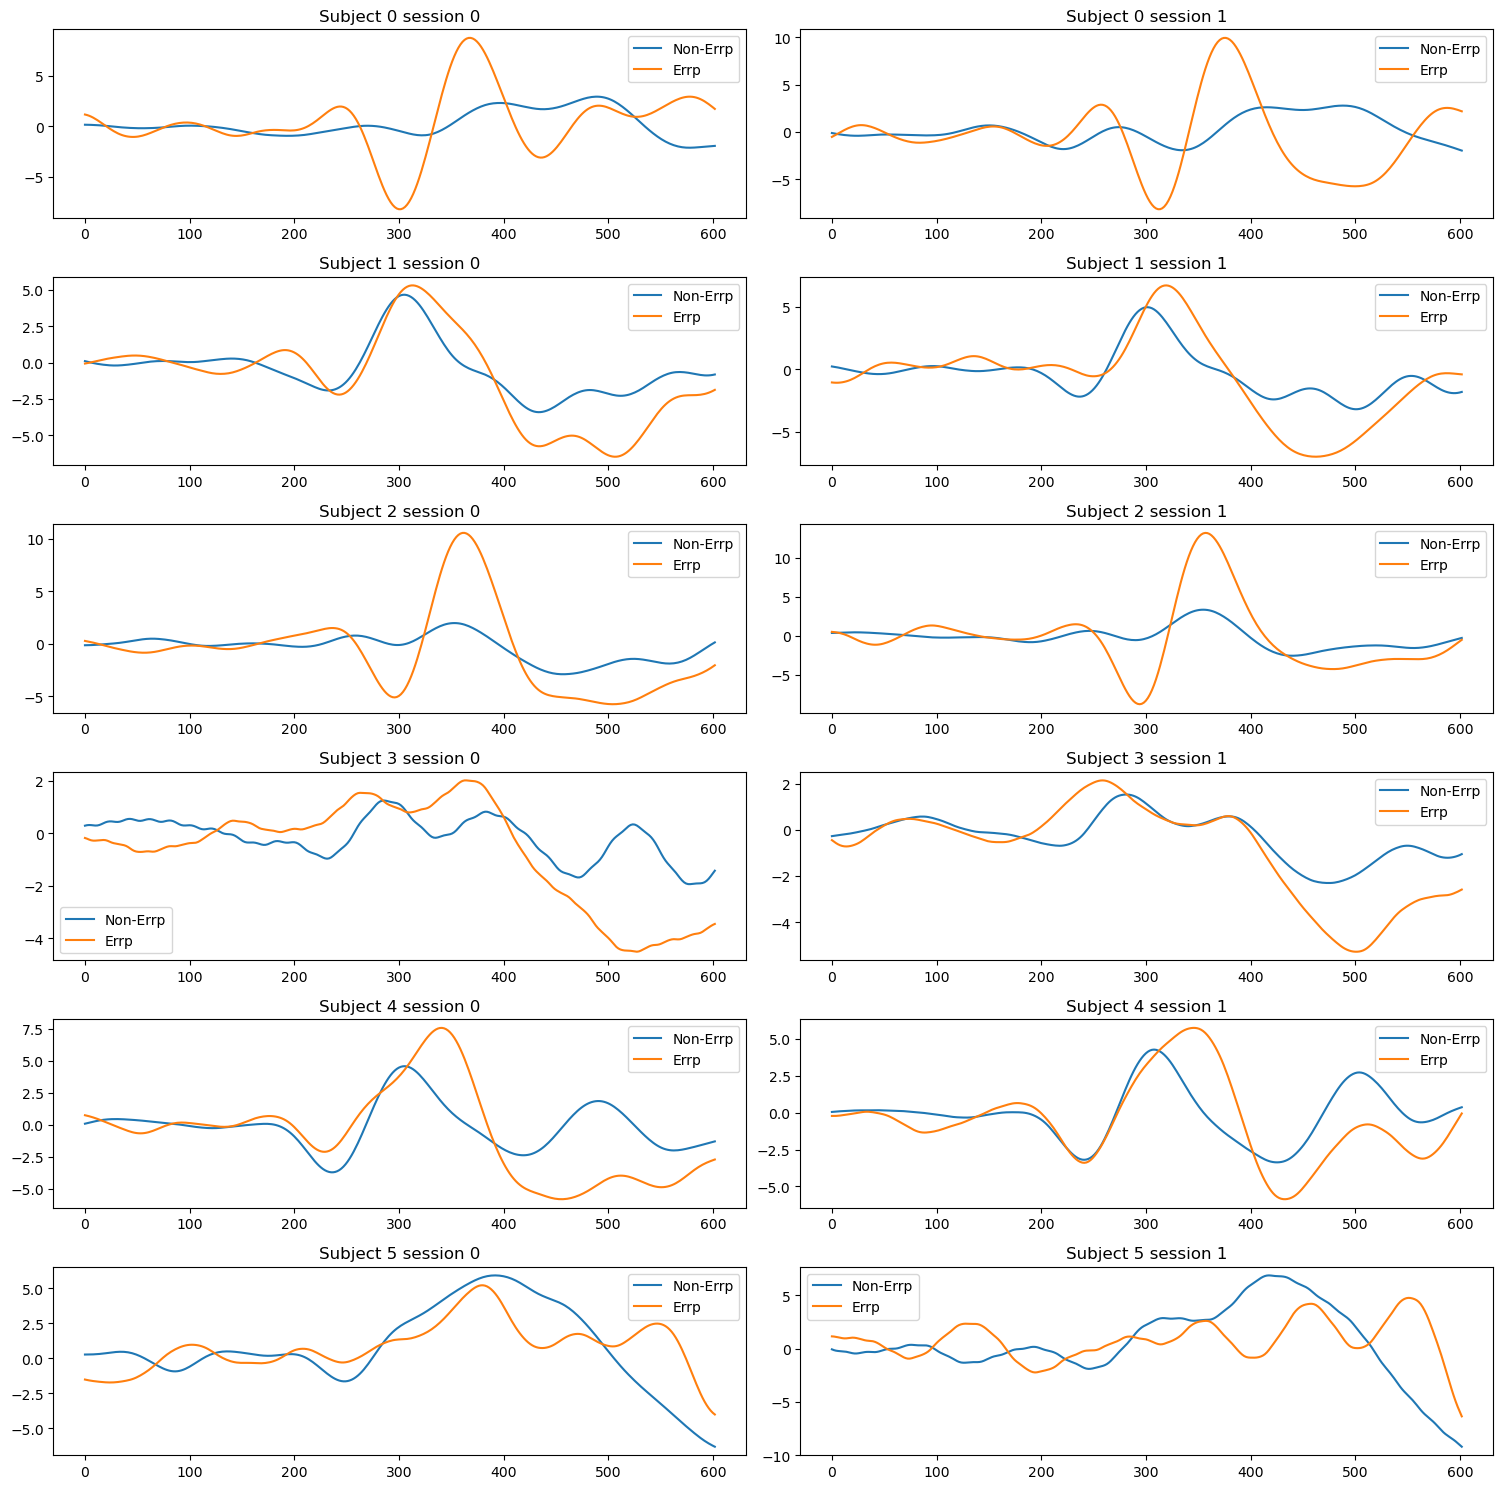

In [6]:
fcz_idx = df.columns.get_loc('FCz')

fcz_len = len(mean_trials[0][0][0][fcz_idx])

duration = fcz_len / 512 * 1000
t = np.linspace(0, duration, fcz_len)

figure, axes = plt.subplots(subjects, sessions, figsize=(15, 15))


for i, subject in enumerate(mean_trials):
    for j, session in enumerate(subject):
        fcz_0 = session[0][fcz_idx]
        fcz_1 = session[1][fcz_idx]

        axes[i, j].plot(t, fcz_0, label='Non-Errp')
        axes[i, j].plot(t, fcz_1, label='Errp')
        axes[i, j].set_title('Subject {subject} session {session}'.format(subject=i, session=j))
        axes[i, j].legend()
       
figure.tight_layout()

Experiment:

In [7]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)


CometLogger will be initialized in online mode


In [8]:
# Load training module
# The preproccesing code is currently quite messy, still need to clean it up
train, val, test = create_dataset('./src/pickle_df')


Selected test subject: 01


In [9]:
count_0 = 0
count_1 = 0

for elem in train:
    if elem[1] == 0:
        count_0 += 1
    else:
        count_1 += 1

print(count_1)
print(count_0)

3562
3562


In [10]:
dm = DataModule(train=train, val=val, test=test, batch_size=16)


In [23]:
model = EEGNetMultiHeaded(chunk_size=308,
                          num_electrodes=64,
                          dropout=0.5,
                          kernel_1=64,
                          kernel_2=16,
                          F1=8,
                          F2=16,
                          D=2,
                          num_classes=2)


model_original = EEGNet(chunk_size=308,
                          num_electrodes=64,
                          dropout=0.5,
                          kernel_1=64,
                          kernel_2=16,
                          F1=8,
                          F2=16,
                          D=2,
                          num_classes=2)


In [12]:
trainer = pl.Trainer(
    max_epochs=10,
    logger=comet_logger
)

trainer_original = pl.Trainer(
    max_epochs=10,
    logger=comet_logger
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training and testing the multi-headed variance-predicting model

In [13]:
trainer.fit(model, datamodule=dm)



  | Name             | Type            | Params
-----------------------------------------------------
0 | block1           | Sequential      | 1.6 K 
1 | block2           | Sequential      | 544   
2 | mean_node        | Linear          | 288   
3 | variance_node    | Sequential      | 288   
4 | sampling_softmax | SamplingSoftmax | 0     
-----------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495

c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottl

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [4460] : (2.680081844329834, 8.85477066040039)
COMET INFO:     val_loss [712]    : (2.701023817062378, 7.646012306213379)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1

In [14]:
trainer.test(model=model, datamodule=dm)


c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        correct_var        │    0.22636151459835718    │
│       incorrect_var       │    0.23603367554881383    │
│         test_acc          │    0.8651982545852661     │
│         test_loss         │    2.9599759578704834     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495
COMET INFO:   Metrics:
COMET INFO:     correct_var   : 0.22636151459835718
COMET INFO:     incorrect_var : 0.23603367554881383
COMET INFO:     test_acc      : 0.8651982545852661
COMET INFO:     test_loss     : 2.9599759578704834
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


[{'test_acc': 0.8651982545852661,
  'test_loss': 2.9599759578704834,
  'correct_var': 0.22636151459835718,
  'incorrect_var': 0.23603367554881383}]

Training the original one-headed model

In [15]:
trainer_original.fit(model_original, datamodule=dm)


c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\marti\Desktop\Bachelors project\bachelors-project\ab4fbee7de6c4acfbce3cb043b0e0495\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name   | Type       | Params
--------------------------------------
0 | block1 | Sequential | 1.6 K 
1 | block2 | Sequential | 544   
2 | lin    | Linear     | 288   
--------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [4460] : (0.1819472461938858, 1.2701029777526855)
COMET INFO:     val_loss [712]    : (0.19186817109584808, 1.0311095714569092)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


In [16]:
trainer_original.test(model=model_original, datamodule=dm)


Testing: 0it [00:00, ?it/s]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8400881290435791     │
│         test_loss         │    0.40024349093437195    │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/marwo22/bachelors-project/ab4fbee7de6c4acfbce3cb043b0e0495
COMET INFO:   Metrics:
COMET INFO:     test_acc  : 0.8400881290435791
COMET INFO:     test_loss : 0.40024349093437195
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


[{'test_acc': 0.8400881290435791, 'test_loss': 0.40024349093437195}]

In [17]:
# Creating two predict datasets of 10 entries each. 
# Normal predict set is 'normal', whereas the zeroed predict set has its FCz channel zeroed

normalPredictSet = predictDataSet(test[:10])
normalPredictLoader = DataLoader(normalPredictSet, batch_size=10, shuffle=False)

editedSet = []

for i, (eeg, label) in enumerate(test[:10]):
    tmp = eeg.copy()
    tmp[47] = np.zeros(308,)  # Replace FCz
    editedSet.append((tmp, label))

zeroedPredictSet = predictDataSet(editedSet)
zeroedPredictLoader = DataLoader(zeroedPredictSet, batch_size=10, shuffle=False)


In [18]:
output1 = trainer.predict(model=model, dataloaders=normalPredictLoader)
output2 = trainer.predict(model=model, dataloaders=zeroedPredictLoader)

print(output1[0][1].mean())
print(output2[0][1].mean())

c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

tensor(0.2277)
tensor(0.2277)


In [20]:
# Also do a test on the Validation set to visualize the variance (Note that this is no valid method of testing the model)

valPredictSet = predictDataSet(val[:30])
valPredictLoader = DataLoader(valPredictSet, batch_size=30, shuffle=False)

output = trainer.predict(model=model, dataloaders=valPredictLoader)
labels = valPredictSet.get_labels()
for i, (prediction, variance) in enumerate(zip(output[0][0], output[0][1])):
    print(prediction, val[i][1], variance)



c:\Users\marti\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

tensor([0.5851, 0.4149]) 1 tensor([0.2325, 0.2325])
tensor([0.6167, 0.3833]) 0 tensor([0.2275, 0.2275])
tensor([0.6189, 0.3811]) 0 tensor([0.2253, 0.2253])
tensor([0.4910, 0.5090]) 0 tensor([0.2435, 0.2435])
tensor([0.6477, 0.3523]) 0 tensor([0.2203, 0.2203])
tensor([0.6707, 0.3293]) 0 tensor([0.2119, 0.2119])
tensor([0.6341, 0.3659]) 0 tensor([0.2230, 0.2230])
tensor([0.7077, 0.2923]) 0 tensor([0.1994, 0.1994])
tensor([0.5442, 0.4558]) 0 tensor([0.2409, 0.2409])
tensor([0.5269, 0.4731]) 0 tensor([0.2415, 0.2415])
tensor([0.4306, 0.5694]) 0 tensor([0.2407, 0.2407])
tensor([0.3616, 0.6384]) 1 tensor([0.2233, 0.2233])
tensor([0.6062, 0.3938]) 0 tensor([0.2302, 0.2302])
tensor([0.5558, 0.4442]) 0 tensor([0.2403, 0.2403])
tensor([0.6198, 0.3802]) 0 tensor([0.2239, 0.2239])
tensor([0.6745, 0.3255]) 0 tensor([0.2107, 0.2107])
tensor([0.5105, 0.4895]) 1 tensor([0.2417, 0.2417])
tensor([0.5839, 0.4161]) 0 tensor([0.2356, 0.2356])
tensor([0.4411, 0.5589]) 1 tensor([0.2384, 0.2384])
tensor([0.61

Test runs (10 epochs)

Subject 1
COMET INFO:     correct_var   : 0.24526300002277765
COMET INFO:     incorrect_var : 0.2487000952699538
COMET INFO:     test_acc      : 0.7383260130882263
COMET INFO:     test_loss     : 3.219019651412964

Subject 2
COMET INFO:     correct_var   : 0.2260321459501493
COMET INFO:     incorrect_var : 0.23518400635999237
COMET INFO:     test_acc      : 0.6910856366157532
COMET INFO:     test_loss     : 3.2498958110809326

Subject 3
COMET INFO:     correct_var   : 0.22918819762528056
COMET INFO:     incorrect_var : 0.23405312742954087
COMET INFO:     test_acc      : 0.6031163930892944
COMET INFO:     test_loss     : 3.429486036300659

Subject 4
COMET INFO:     correct_var   : 0.21242563703894976
COMET INFO:     incorrect_var : 0.22683236699740444
COMET INFO:     test_acc      : 0.8202348947525024
COMET INFO:     test_loss     : 2.9433605670928955

Subject 5
COMET INFO:     correct_var   : 0.2306651021589556
COMET INFO:     incorrect_var : 0.2371705954791413
COMET INFO:     test_acc      : 0.774449348449707
COMET INFO:     test_loss     : 3.1388168334960938

Subject 6
COMET INFO:     correct_var   : 0.21972788197611084
COMET INFO:     incorrect_var : 0.2156169066196063
COMET INFO:     test_acc      : 0.5225631594657898
COMET INFO:     test_loss     : 4.015593528747559




Average 0.692 test_acc